In [18]:
from numba import *
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from PIL.Image import ANTIALIAS
from os import listdir
from scipy.ndimage import correlate
import os

In [5]:
DoG_params = {'img_size': (250, 160), 'DoG_size': 7, 'std1': 1., 'std2': 2.}  # img_size is (col size, row size)
total_time = 15
network_params = [{'Type': 'input', 'num_filters': 1, 'pad': (0, 0), 'H_layer': DoG_params['img_size'][1],
                   'W_layer': DoG_params['img_size'][0]},
                  {'Type': 'conv', 'num_filters': 4, 'filter_size': 5, 'th': 10.},
                  {'Type': 'pool', 'num_filters': 4, 'filter_size': 7, 'th': 0., 'stride': 6},
                  {'Type': 'conv', 'num_filters': 20, 'filter_size': 17, 'th': 60.},
                  {'Type': 'pool', 'num_filters': 20, 'filter_size': 5, 'th': 0., 'stride': 5},
                  {'Type': 'conv', 'num_filters': 20, 'filter_size': 5, 'th': 2.}]

In [13]:
@jit
def DoG_norm_CPU(img_out, img_in, image_size, win_size):

    sumation = .0001
    for idx in range(img_in.shape[0]):
        for idy in range(img_in.shape[1]):
            j = 0 if idy-win_size < 0 else idy-win_size
            while j <= (image_size[1]-1 if idy+win_size > image_size[1]-1 else idy+win_size):
                i = 0 if idx - win_size < 0 else idx - win_size
                while i <= (image_size[0]-1 if idx+win_size > image_size[0]-1 else idx+win_size):
                    sumation += img_in[i, j]
                    i += 1
                j += 1
            mean = sumation / ((2*win_size+1)**2)
            img_out[idx, idy] = img_in[idx, idy] / mean
    return img_out
def DoG(size, s1, s2):
    """
        Generates a filter window of size size x size with std of s1 and s2
    """
    r = np.arange(size)+1
    x = np.tile(r, [size, 1])
    y = x.T
    d2 = (x-size/2.-0.5)**2 + (y-size/2.-0.5)**2
    filt = 1/np.sqrt(2*np.pi) * (1/s1 * np.exp(-d2/(2*(s1**2))) - 1/s2 * np.exp(-d2/(2*(s2**2))))
    filt -= np.mean(filt[:])
    filt /= np.amax(filt[:])
    return filt
def DoG_filter(path_img, filt, img_size, total_time, num_layers):
    """
        DoG filter implementation based on Kheradpisheh, S.R., et al. 'STDP-based spiking deep neural networks 
        for object recognition'. arXiv:1611.01421v1 (Nov, 2016)
    """

    # Open image, convert to grayscale and resize
    img = Image.open(path_img)
    img = img.convert('L')
    img = img.resize(img_size, ANTIALIAS)
    img = np.asarray(img.getdata(), dtype=np.float64).reshape((img.size[1], img.size[0]))

    # Apply filter
    img = correlate(img, filt, mode='constant')

    # Border
    border = np.zeros(img.shape)
    border[5:-5, 5:-5] = 1.
    img = img * border

    # Threshold
    img = (img >= 15).astype(int) * img
    img = np.abs(img)  # Convert -0. to 0.

    # DoG Normalization
    # img_out = DoG_normalization(img)
    # img_out = DoG_normalization_CPU(img)
    img_out = img

    # Convert to spike times
    I = np.argsort(1 / img_out.flatten())  # Get indices of sorted latencies
    lat = np.sort(1 / img_out.flatten())  # Get sorted latencies
    I = np.delete(I, np.where(lat == np.inf))  # Remove infinite latencies indexes
    II = np.unravel_index(I, img_out.shape)  # Get the row, column and depth of the latencies in order
    t_step = np.ceil(np.arange(I.size) / ((I.size) / (total_time - num_layers))).astype(np.uint8)
    II += (t_step,)
    spike_times = np.zeros((img_out.shape[0], img_out.shape[1], total_time))
    spike_times[II] = 1

    return spike_times

In [14]:
filt = DoG(DoG_params['DoG_size'], DoG_params['std1'], DoG_params['std2'])
num_layers = len(network_params)
img_size = DoG_params['img_size']

In [15]:
TRAIN_PATH = "../datasets/TrainingSet/Face"

In [35]:
names = listdir("../datasets/TrainingSet/Face")
file_name = 'n02691156_3.jpg'

In [42]:
def dog2video(img_path, filt, img_size, total_time, num_layers):
    st = DoG_filter(img_path, filt, img_size, total_time, num_layers)
    st = np.expand_dims(st, axis=2)
    print('spike shape: ', st.shape)
    fps = 24    #保存视频的FPS，可以适当调整
    #可以用(*'DVIX')或(*'X264'),如果都不行先装ffmepg: sudo apt-get install ffmepg
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    videoWriter = cv2.VideoWriter('%s.avi' % img_path.rstrip('.jpg'),fourcc,fps,(st.shape[1],st.shape[0]))#最后一个是保存图片的尺寸
    for t in range(total_time):
        time_slice = np.squeeze(np.array(st[:,:,:,t]))
        time_slice *= 255
        plt.imsave('tmp.jpg', time_slice)
        frame = cv2.imread('tmp.jpg')
        videoWriter.write(frame)
    os.remove('tmp.jpg')
    videoWriter.release()

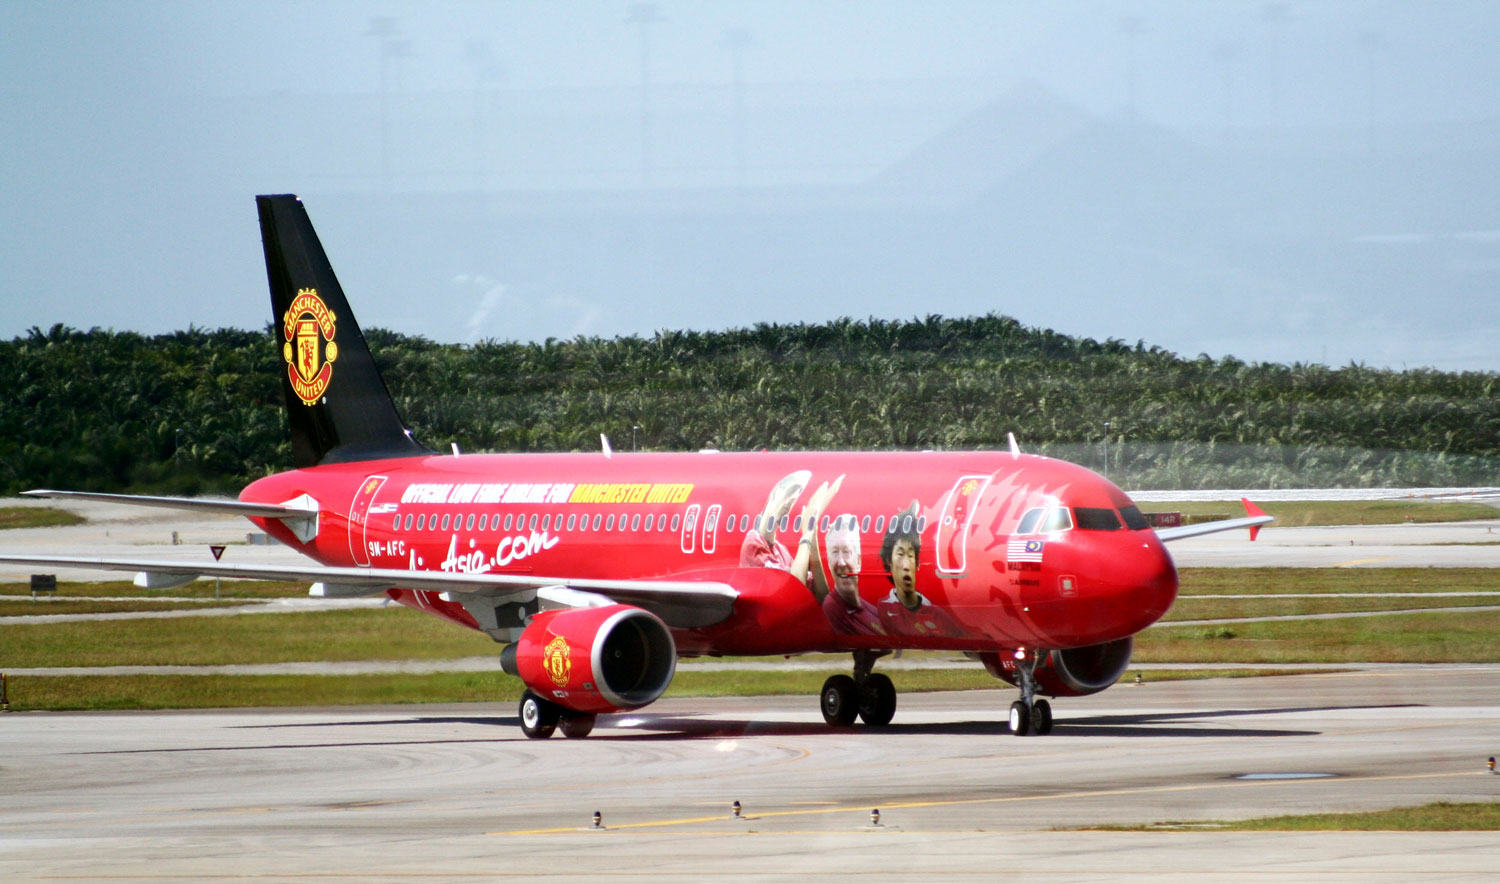

In [36]:
Image.open(os.path.join(file_name))

In [38]:
import cv2

In [43]:
dog2video(file_name, filt, img_size, total_time, num_layers)

spike shape:  (160, 250, 1, 15)


/home/pyc/tfenv/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/home/pyc/tfenv/lib/python3.5/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
